In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from helper import get_performance, get_conflict_commit_performance, get_merge_coflict_mispredicted_region_test
from sklearn.metrics import classification_report
EPOCHS = 700
BATCH_SIZE = 2048
ACTIVATION = 'swish'
LEARNING_RATE = 0.0007
FOLDS = 5

In [2]:
TRAIN_PATH_P2 = "/data/BRCTP/p2_train.csv"
TEST_PATH_P2 = "/data/BRCTP/p2_test.csv"
TRAIN_PATH_P3 = "/data/BRCTP/p3_train.csv"
TEST_PATH_P3 = "/data/BRCTP/p3_test.csv"
TRAIN_PATH_P4 = "/data/BRCTP/p4_train.csv"
TEST_PATH_P4 = "/data/BRCTP/p4_test.csv"

train_p2 = pd.read_csv(TRAIN_PATH_P2)
test_p2 = pd.read_csv(TEST_PATH_P2)
train_p3 = pd.read_csv(TRAIN_PATH_P3)
test_p3 = pd.read_csv(TEST_PATH_P3)
train_p4 = pd.read_csv(TRAIN_PATH_P4)
test_p4 = pd.read_csv(TEST_PATH_P4)

all_data = pd.concat([train_p2, train_p3, train_p4, test_p2, test_p3, test_p4])

all_data = all_data.sample(frac=1, random_state=1).reset_index(drop=True)

X = all_data.drop(['OOSLA'], axis=1)
y = all_data[['OOSLA']]

print(X.shape)
print(y.shape)
print('------')
print(y.value_counts())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

(8202, 24)
(8202, 1)
------
OOSLA
0        5707
1        2495
dtype: int64


# Default Model

In [3]:
model_default = DecisionTreeClassifier()
scores_default = cross_val_score(model_default, X=X_train, y=y_train, cv = FOLDS)
model_default.fit(X_train, y_train)
y_pred_default = model_default.predict(X_test)

print(classification_report(y_test, y_pred_default))

              precision    recall  f1-score   support

           0       0.86      0.87      0.86      1429
           1       0.69      0.66      0.68       622

    accuracy                           0.81      2051
   macro avg       0.77      0.77      0.77      2051
weighted avg       0.81      0.81      0.81      2051



# SMOTE Oversampling

In [4]:
# SMOTE Oversampling
    # Transform data 
oversample = SMOTE()
X_train_sm, y_train_sm = oversample.fit_resample(X_train, y_train)
model_SMOTE = DecisionTreeClassifier()
scores_SMOTE = cross_val_score(model_SMOTE, X=X_train_sm, y=y_train_sm, cv = FOLDS)
model_SMOTE.fit(X_train_sm, y_train_sm)
y_pred_SMOTE = model_SMOTE.predict(X_test)

print(classification_report(y_test, y_pred_SMOTE))

              precision    recall  f1-score   support

           0       0.87      0.83      0.85      1429
           1       0.65      0.72      0.69       622

    accuracy                           0.80      2051
   macro avg       0.76      0.78      0.77      2051
weighted avg       0.81      0.80      0.80      2051



In [8]:
y_train_sm

,OOSLA
0,0
1,1
2,0
3,0
4,1
...,...
8551,1
8552,1
8553,1
8554,1


## MAPS

In [5]:
import time 
import sys
sys.path.insert(1, './mmd')
from mmd import diagnoser
from scipy import stats as st
import numpy
#notebook's library
%matplotlib inline
from helper import get_top_f1_rules, get_relevent_attributs_target, get_MMD_results, get_biased_features, get_BGMD_results
from helper import generateTrain_data_Weights

In [10]:
def mispredict_label(row):
    if row['OOSLA'] == row['pred']:
        return False
    return True
#use first default model result to detect mispredictions
default_result = pd.concat([X_test, y_test], axis=1, join='inner')
default_result.loc[:,"pred"] = y_pred_default

# default_result = default_result.loc[default_result["is_conflict"] == 1]
default_result_copy = default_result.copy()
X_test_copy = default_result.copy().drop(['OOSLA', 'pred'], axis=1)
X_test_copy['mispredict'] = default_result_copy.apply(lambda row: mispredict_label(row), axis=1)


In [11]:
settings = diagnoser.Settings
settings.all_rules = False

# Get relevent attributes and target 
relevant_attributes, Target = get_relevent_attributs_target(X_test_copy)
# Geerate MMD rules and correspodning information
MMD_rules, MMD_time, MMD_Features = get_MMD_results(X_test_copy, relevant_attributes, Target, settings)

#Get biased attributes this time 
biased_attributes = get_biased_features(X_test_copy, relevant_attributes)

BGMD_rules, BGMD_time, BGMD_Features = get_BGMD_results(X_test_copy, biased_attributes, Target, settings)


print('MMD Spent:', MMD_time, 'BGMD Spent:', BGMD_time)
MMD_rules, BGMD_rules

Original Rule
Subgroup Discovery Result

Found 3 subgroups
Dataset
Target: mispredict=True
# Rows:	2051
# Cols:	25
% Target in dataset 19.31%
Subgroup: meanCommentSize>1285.75
% of subgroup in population (Full Dataset):	0.2% (4 rows)
Precision: P(mispredict=True | meanCommentSize>1285.75) = 100.0%
Recall: P(meanCommentSize>1285.75 | mispredict=True) = 1.01%
Subgroup: lateTriageDays>62
% of subgroup in population (Full Dataset):	0.29% (6 rows)
Precision: P(mispredict=True | lateTriageDays>62) = 66.67%
Recall: P(lateTriageDays>62 | mispredict=True) = 1.01%
Subgroup: activitysequence>0.11492747099999999
% of subgroup in population (Full Dataset):	61.63% (1264 rows)
Precision: P(mispredict=True | activitysequence>0.11492747099999999) = 27.93%
Recall: P(activitysequence>0.11492747099999999 | mispredict=True) = 89.14%
time: 28.989266872406006
Feature Number 25

###############################

BGMD Rule
Subgroup Discovery Result

Found 3 subgroups
Dataset
Target: mispredict=True
# Rows:	2051

([[0.4253012048192771, 'activitysequence>0.11492747099999999'],
  [0.02, 'meanCommentSize>1285.75'],
  [0.019900497512437814, 'lateTriageDays>62']],
 [[0.4253012048192771, 'activitysequence>0.11492747099999999'],
  [0.02, 'meanCommentSize>1285.75'],
  [0.019900497512437814, 'lateTriageDays>62']])

In [13]:
from helper import get_test_data_in_misprediction_areas

final_result = pd.concat([X_test, y_test], axis=1, join='inner')

indexes_in_misprediction_area = get_test_data_in_misprediction_areas(BGMD_rules, X_test)
y_actual_MD = []

for index in indexes_in_misprediction_area:
        y_actual_MD.append(final_result.loc[index]['OOSLA'])


In [14]:
from collections import Counter
from sklearn.metrics import precision_recall_fscore_support
grid_upweights = range(1, 101)
best_weight_all = 1
best_f1_all = 0
best_weight_mis = 1
best_f1_mis = 0
f1_all = []
f1_mispredicted = []
acc_all = []
acc_mispredicted = []
recall_all = []
recall_mispredicted = []
for upweight in grid_upweights:
    # give extra weights to training samples in mispredited areas 
#     print('Upweight_value: ', upweight)
    weights = generateTrain_data_Weights(BGMD_rules, X_train, upweight_value=upweight)

    c = Counter(weights)
#     print(c.items())

    MAPS_model = DecisionTreeClassifier()
    scores_MAPS = cross_val_score(MAPS_model, X=X_train, y=y_train, cv = FOLDS)
    MAPS_model.fit(X_train, y_train, sample_weight = weights)

    y_pred_MAPS = MAPS_model.predict(X_test)

    total_result = get_conflict_commit_performance(X_test, y_test, y_pred_MAPS)
    
    acc_all.append(total_result[0][0])
    recall_all.append(total_result[1][0])
    f1_all.append(total_result[2][0])
    
    final_result['y_pred_MAPS'] = y_pred_MAPS
    y_pred_MAPS_MD = []
    for index in indexes_in_misprediction_area:
        y_pred_MAPS_MD.append(final_result.loc[index]['y_pred_MAPS'])
        
    MAPS_MD_metric = precision_recall_fscore_support(y_actual_MD, y_pred_MAPS_MD, labels=[1])
    
    acc_mispredicted.append(MAPS_MD_metric[0][0])
    recall_mispredicted.append(MAPS_MD_metric[1][0])
    f1_mispredicted.append(MAPS_MD_metric[2][0])
    
    if total_result[2][0] > best_f1_all:
        best_f1_all = total_result[2][0]
        best_weight_all = upweight;
    if MAPS_MD_metric[2][0] > best_f1_mis:
        best_f1_mis = MAPS_MD_metric[2][0]
        best_weight_mis = upweight

Best weight on all is:  97
Best weight on misprediction area is:  97


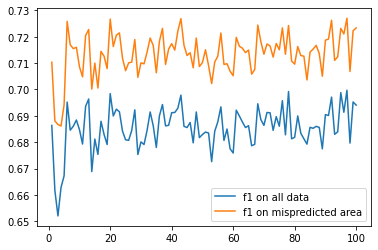

In [15]:
print("Best weight on all is: ", best_weight_all)
print("Best weight on misprediction area is: ", best_weight_mis)
plt.plot(grid_upweights, f1_all, label = "f1 on all data")
plt.plot(grid_upweights, f1_mispredicted, label = "f1 on mispredicted area")
plt.legend()
plt.show()
dict = {'acc_all': acc_all, 'recall_all': recall_all, 'f1_all': f1_all, 'acc_mispredicted': acc_mispredicted, 'recall_mispredicted': recall_mispredicted, 'f1_mispredicted': f1_mispredicted}
out = pd.DataFrame(dict)
# out.to_csv('Merge_Conflict_Java_DT.csv')

In [16]:
# MAPS all
acc_all[best_weight_all-1], recall_all[best_weight_all-1], f1_all[best_weight_all-1]

(0.7065573770491803, 0.6929260450160771, 0.6996753246753247)

In [17]:
# MAPS mispredict area
acc_mispredicted[best_weight_mis-1], recall_mispredicted[best_weight_mis-1], f1_mispredicted[best_weight_mis-1]

(0.7452339688041595, 0.7095709570957096, 0.7269653423499578)

In [19]:
get_merge_coflict_mispredicted_region_test(X_test, y_test, y_pred_default, y_pred_SMOTE, y_pred_MAPS, BGMD_rules, ylabel='OOSLA')

Default: (array([0.7195122]), array([0.68151815]), array([0.7]), array([606]))
SMOTE: (array([0.70062696]), array([0.73762376]), array([0.71864952]), array([606]))


# JTT

In [20]:
from helper import generate_JTT_Weights

In [21]:
X_train_1st, X_val, y_train_1st, y_val = train_test_split(X_train, y_train, test_size = 0.33, random_state = 29)

model_JTT = DecisionTreeClassifier()
scores_JTT_1st = cross_val_score(model_JTT, X_train_1st, y=y_train_1st, cv = FOLDS)
model_JTT.fit(X_train_1st, y_train_1st)
y_pred_JTT_val = model_JTT.predict(X_val)

In [22]:
y_val

,OOSLA
6538,0
3577,0
4149,1
4702,0
1704,0
...,...
6787,0
878,0
8000,0
7911,0


In [24]:
grid_upweights_JTT = [10, 20, 30, 40, 50]
best_weight_all_JTT = 1
best_f1_all_JTT = 0
best_weight_mis_JTT = 1
best_f1_mis_JTT = 0
f1_all_JTT = []
f1_mispredicted_JTT = []
precision_all_JTT = []
precision_mispredicted_JTT = []
recall_all_JTT = []
recall_mispredicted_JTT = []

for i, upweight in enumerate(grid_upweights_JTT):
    weights = generate_JTT_Weights(y_val['OOSLA'].to_list(), y_pred_JTT_val, weight = upweight)
    
    #combine train and validate data
    weights = np.concatenate((np.ones(len(X_train_1st)), weights))
    y_train_2nd = np.concatenate((y_train_1st, y_val))
    X_train_2nd = pd.concat([X_train_1st, X_val])
    X_train_2nd['val_weight'] = weights
    X_train_2nd['target'] = y_train_2nd
    X_train_2nd = X_train_2nd.sample(frac=1, random_state=1).reset_index(drop=True)
    weights = X_train_2nd['val_weight'].to_list()
    y_train_2nd = X_train_2nd['target']
    X_train_2nd = X_train_2nd.drop(['val_weight', 'target'], axis=1)
    
    model_JTT = DecisionTreeClassifier()
    scores_JTT_2nd = cross_val_score(model_JTT, X_train_2nd, y=y_train_2nd, cv = FOLDS)
    model_JTT.fit(X_train_2nd, y_train_2nd, sample_weight = weights)
    y_pred_JTT = model_JTT.predict(X_test)
    
    total_result_JTT = get_conflict_commit_performance(X_test, y_test, y_pred_JTT)
    
    precision_all_JTT.append(total_result_JTT[0][0])
    recall_all_JTT.append(total_result_JTT[1][0])
    f1_all_JTT.append(total_result_JTT[2][0])
    
    final_result['y_pred_JTT'] = y_pred_JTT
    y_pred_JTT_MD = []
    for index in indexes_in_misprediction_area:
        y_pred_JTT_MD.append(final_result.loc[index]['y_pred_JTT'])
        
    JTT_MD_metric = precision_recall_fscore_support(y_actual_MD, y_pred_JTT_MD, labels=[1])
    
    precision_mispredicted_JTT.append(JTT_MD_metric[0][0])
    recall_mispredicted_JTT.append(JTT_MD_metric[1][0])
    f1_mispredicted_JTT.append(JTT_MD_metric[2][0])
    
    if total_result_JTT[2][0] > best_f1_all_JTT:
        best_f1_all = total_result_JTT[2][0]
        best_weight_all = i;
    if JTT_MD_metric[2][0] > best_f1_mis_JTT:
        best_f1_mis = JTT_MD_metric[2][0]
        best_weight_mis = i

In [25]:
print("JTT Best weight on all is: ", grid_upweights_JTT[best_weight_all])
print("JTT Best weight on mispredicted area is: ", grid_upweights_JTT[best_weight_mis])

JTT Best weight on all is:  50
JTT Best weight on mispredicted area is:  50


In [26]:
# JTT all
precision_all_JTT[best_weight_all_JTT-1], recall_all_JTT[best_weight_all_JTT-1], f1_all_JTT[best_weight_all_JTT-1]

(0.6869158878504673, 0.7090032154340836, 0.6977848101265823)

In [27]:
# JTT mispredict area
precision_mispredicted_JTT[best_weight_mis_JTT-1], recall_mispredicted_JTT[best_weight_mis_JTT-1], f1_mispredicted_JTT[best_weight_mis_JTT-1]

(0.7325581395348837, 0.7277227722772277, 0.7301324503311257)